In [150]:
import slim_conservation_scoring.seqtools.general_utils as tools
import pandas as pd
import numpy as np
import slim_conservation_scoring.pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"

# %load_ext autoreload
# %autoreload 2

# import score key

In [151]:
def table_file_converter(table_file):
    return table_file.replace("/home/jch/Documents/08-benchmark", "..")


score_key_file = "../benchmark/benchmark_v4/p3_conservation/wide_form_tables_with_scores/score_key.csv"
score_key_df = pd.read_csv(score_key_file)
colmap = {
    "aln_property_entropy": "property_entropy",
    "aln_shannon_entropy": "shannon_entropy",
}
for i, row in score_key_df.iterrows():
    if row["score_key"] in colmap:
        score_key_df.at[i, "columnwise_score_function_name"] = colmap[row["score_key"]]

score_key_df = score_key_df.fillna("MSA")


def get_num_passing(table_file, score_key="hit_z_scores", filename_converter=None):
    if filename_converter is not None:
        table_file = filename_converter(table_file)
    df = pd.read_csv(table_file)
    return (~df[score_key].isna()).sum()


score_key_df["num_passing"] = score_key_df["table_file"].apply(
    get_num_passing, filename_converter=table_file_converter
)
score_key_df.head(10)

,score_index,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2464
1,1.0,MSA - MAFFT,Tetrapoda,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2464
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2606
3,3.0,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2606
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2404
5,5.0,MSA - MAFFT,Metazoa,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2404
6,6.0,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,shannon_entropy,2663
7,7.0,Pairwise,Tetrapoda,pairk_aln_lf5_rf5_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,shannon_entropy,2565
8,8.0,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663
9,9.0,Pairwise,Tetrapoda,pairk_aln_lf5_rf5_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,property_entropy,2565


In [152]:
for i in score_key_df.score_key.unique(): print(i)

aln_property_entropy
aln_shannon_entropy
pairk_aln_lf0_rf0_edssmat50
pairk_aln_lf5_rf5_edssmat50
pairk_aln_lf0_rf0_blosum62
pairk_aln_lf0_rf0_grantham
pairk_aln_needleman_lf0_rf0_edssmat50
pairk_aln_lf2_rf2_edssmat50
pairk_aln_lf10_rf10_edssmat50
pairk_aln_embedding_lf0_rf0
pairk_aln_dr_bert_embedding_lf0_rf0


## removing shannon entropy

In [153]:
score_key_filt=score_key_df[score_key_df['columnwise_score_function_name']=='property_entropy'].copy()

## remove alternate matrices and more unusual flank sizes

In [154]:
score_key_filt = score_key_filt[
    ~score_key_filt["score_key"].isin(
        [
            "pairk_aln_lf2_rf2_edssmat50",
            "pairk_aln_lf10_rf10_edssmat50",
            "pairk_aln_needleman_lf0_rf0_edssmat50",
            "pairk_aln_lf0_rf0_blosum62",
            "pairk_aln_lf5_rf5_blosum62",
            "pairk_aln_lf0_rf0_grantham",
        ]
    )
]
score_key_filt.score_key.unique()
# check if the column contains duplicates
score_key_filt=score_key_filt.set_index('score_index', drop=True, verify_integrity=True) # verify_integrity checks for duplicates already

# get scores

## import and merge scores into 1 table

In [155]:
def import_score_table(score_index_df, score_index, filename_converter=None):
    table_file = score_index_df.loc[score_index, 'table_file']
    if filename_converter is not None:
        table_file = filename_converter(table_file)
    return pd.read_csv(table_file)

def import_multiple_scores(score_index_df, score_index_list, score_colname='hit_z_scores', filename_converter=None):
    df = import_score_table(score_index_df, score_index_list[0], filename_converter=filename_converter)
    df=df[
        [
            'reference_index',
            'ELM_motif_class',
            'verified interaction',
            'regex',
            'UniprotID',
            'name',
            'gene_id',
            'hit end position',
            'hit start position',
            'hit_sequence',
            'json_file',
            'bg_STD',
            score_colname,
        ]
    ]
    df = df.rename(columns={score_colname: score_index_list[0], 'bg_STD': f'{score_index_list[0]}-bg_STD'})
    for score_index in score_index_list[1:]:
        df2 = import_score_table(score_index_df, score_index, filename_converter=filename_converter)
        df2 = df2[['reference_index', score_colname, 'bg_STD']]
        df2 = df2.rename(columns={score_colname: score_index, 'bg_STD': f'{score_index}-bg_STD'})
        df = pd.merge(df, df2, on='reference_index', how='outer')
    return df

In [156]:
score_indexes = list(score_key_filt.index)
zscores = import_multiple_scores(score_key_filt, score_indexes, filename_converter=table_file_converter)
zscores['ELM_motif_class'] = zscores['ELM_motif_class'].replace('enah_LPPPP_FPPPP', 'Ena/VASP ([FL]PPPP)')
zscores['hit_length'] = zscores['hit_sequence'].apply(len)
zscores.loc[0]

reference_index                                                         0
ELM_motif_class                                            LIG_AP2alpha_2
verified interaction                                                 True
regex                                                              DP[FW]
UniprotID                                                          O08838
name                                                                  NaN
gene_id                                                    10116_0:004cdf
hit end position                                                      358
hit start position                                                    356
hit_sequence                                                          DPF
json_file               /home/jch/Documents/08-benchmark/benchmark/ben...
0.0-bg_STD                                                       0.203729
0.0                     [1.312758616199497, 1.3127585479190254, 1.3127...
2.0                     [1.27858206472

## position weights for average score of motif

Generate "weights" of all 1's for the 14-3-3 SLiM b/c the regex is variable length

In [157]:
temp = zscores[zscores['ELM_motif_class']=='LIG_14-3-3_CanoR_1'].copy()
l14_weights = {}
for l in temp['hit_length'].unique():
    l14_weights[l] = np.array([1.0]*l)

position_weights = {
    "DOC_WW_Pin1_4": np.array([0, 0, 0, 1, 1, 0]),  # ...([ST])P.
    "LIG_AP2alpha_2": np.array([1, 1, 1]),  # DP[FW]
    "LIG_EH_1": np.array([0, 1, 1, 1, 0]),  # .NPF.
    "LIG_SH2_GRB2like": np.array([1, 1, 1, 0]),  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": np.array([1, 0, 1, 0, 1, 1]),  # P.[AP].PR
    "Ena/VASP ([FL]PPPP)": np.array([1, 1, 0, 1, 1]),  # [FWYL]P.[AFILTVYWP]P
    "TRAF6": np.array([0,0,0,1,0,1,0,0,1]) # ...P.E..[FYWDE]
}# could use this for a weighted average score

zscores['mask_array'] = zscores.apply(lambda x: position_weights[x['ELM_motif_class']] if x['ELM_motif_class'] in position_weights else l14_weights[x['hit_length']], axis=1)

## remove any entries that don't have valid values for all of the scores

In [158]:
l = len(zscores)
print('require all benchmark entries to have all MSA entries')
zscores=zscores.dropna(subset=score_key_filt[score_key_filt['aln_type']=='MSA - MAFFT'].index).copy()
print(f'dropped {l-len(zscores)} entries')

require all benchmark entries to have all MSA entries
dropped 745 entries


In [159]:
zscores[score_indexes].apply(lambda x: list(x.dropna().index), axis=1).value_counts()

[0.0, 2.0, 4.0, 8.0, 9.0, 19.0, 22.0, 26.0, 27.0, 30.0, 31.0, 34.0, 35.0, 38.0, 39.0]    2203
[0.0, 2.0, 4.0, 8.0, 19.0, 26.0, 30.0, 31.0, 34.0, 35.0, 38.0, 39.0]                       20
Name: count, dtype: int64

In [160]:
print('require all benchmark entries to have the other scores\n will drop:')
print(f'{zscores[score_indexes].isna().any(axis=1).sum()} entries')
zscores=zscores.dropna(subset=score_indexes).copy()
print(f'dropped {l-len(zscores)} entries total')
print(f'number of unique reference indexes: {len(zscores['reference_index'].unique())}')

require all benchmark entries to have the other scores
 will drop:
20 entries
dropped 765 entries total
number of unique reference indexes: 2203


## convert the scores to lists (they are strings here)

In [161]:
from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(lambda x: literal_eval(x) if type(x) is str else x)

## add the kibby scores to the table
see `../src/data_processing/BENCHMARK_processing/p5_kibby_conservation/`

In [162]:
def kibby_score_str_2_list(s):
    return np.array([float(x) for x in s.split(' ')])

def extract_hit(s: pd.Series, colname: str):
    st = s['hit start position']
    end = s['hit end position']
    hit = s[colname][st:end+1]
    return hit

def get_kibby_zscores(json_file, scores, filename_converter=None):
    '''
    import the json to get the idr coordinates to calculate a z-score. 
    Note that there are not gaps so no masking is needed
    '''
    og = group_tools.ConserGene(json_file, filepath_converter=filename_converter)
    assert len(scores) == len(og.query_sequence)
    idr_scores=scores[og.idr_start:og.idr_end+1]
    assert len(idr_scores)==len(og.query_idr_sequence)
    z_scores=tools.z_score_comparison(scores, idr_scores)
    return z_scores, np.std(idr_scores)

kibby_score_file = '../benchmark/benchmark_v4/kibby_scores/gene_seqs_kibby_scores.csv'
kibby_df = pd.read_csv(kibby_score_file)
kibby_df['gene_id'] = kibby_df['header'].apply(lambda x: x.split('\t')[0])
kibby_df.conservation = kibby_df.conservation.apply(kibby_score_str_2_list)
kibby_df=kibby_df.drop(columns=['header'])

zscores=pd.merge(zscores, kibby_df, on='gene_id', how='left')
zscores['hit2'] = zscores.apply(extract_hit, args=['sequence'], axis=1)
# zscores['kibby_hit_scores'] = zscores.apply(extract_hit, args=['conservation'], axis=1) # these aren't the z-scores
# check that the hit sequences are the same
assert (zscores['hit2'] == zscores['hit_sequence']).all(), 'hit sequences from kibby are not all the same as the hit seqs in the table'
# zscores['kibby_zscores'] = zscores.apply(lambda x: get_kibby_zscores(x['json_file'], x['conservation'], filename_converter=table_file_converter), axis=1)
zscores[['kibby_zscores', 'kibby_hit_zscores-bg_STD']] = zscores.apply(lambda x: get_kibby_zscores(x['json_file'], x['conservation'], filename_converter=table_file_converter), axis=1, result_type='expand')
zscores['kibby_hit_zscores'] = zscores.apply(extract_hit, args=['kibby_zscores'], axis=1)
zscores=zscores.drop(columns=['hit2', 'sequence', 'conservation', 'kibby_zscores'])
zscores['kibby_hit_zscores']=zscores['kibby_hit_zscores'].apply(lambda x: [float(i) for i in x])
score_indexes.append('kibby_hit_zscores')

### add kibby to the score indexes

Note that the kibby score is broadcast to each level

In [163]:
temp = pd.DataFrame({'score_index': ['kibby_hit_zscores']*3, 'level': ['Metazoa', 'Tetrapoda', 'Vertebrata']}, columns=score_key_df.columns)
score_key_df2=pd.concat([score_key_df, temp], ignore_index=True).fillna('kibby')
score_key_df2.tail()

,score_index,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
38,38.0,Pairwise embedding,Metazoa,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844
39,39.0,Pairwise embedding,Metazoa,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844
40,kibby_hit_zscores,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby
41,kibby_hit_zscores,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
42,kibby_hit_zscores,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby


## filter by std dev

In [164]:
# examine an outlier
temp = zscores.copy()
temp['ave_score'] = temp[0.0].apply(np.mean)
temp.sort_values('ave_score', ascending=True)[[0.0, '0.0-bg_STD', 'ELM_motif_class', 'gene_id', 'reference_index', 'hit_sequence', 'mask_array', 'ave_score']].head()

,0.0,0.0-bg_STD,ELM_motif_class,gene_id,reference_index,hit_sequence,mask_array,ave_score
1103,"[-16.57557514526067, -15.764554913761827, -16....",0.048343,LIG_SH3_CIN85_PxpxPR_1,9606_0:003cd4,1497,PPPSPR,"[1, 0, 1, 0, 1, 1]",-16.055066
600,"[-7.308815340489188, -8.411150759151825, -8.34...",0.082483,LIG_EH_1,9606_0:005014,761,RNPFI,"[0, 1, 1, 1, 0]",-7.942713
1902,"[-4.444740511246241, -4.343337174333967, -4.33...",0.159923,Ena/VASP ([FL]PPPP),9606_0:003345,2583,LPPPP,"[1, 1, 0, 1, 1]",-4.340071
1081,"[-3.893655573894856, -4.387340706651061, -4.05...",0.127993,LIG_SH3_CIN85_PxpxPR_1,9606_0:0049c7,1462,PTAPPR,"[1, 0, 1, 0, 1, 1]",-4.011252
1896,"[-3.9784721688587767, -3.9784723001861835, -3....",0.172992,Ena/VASP ([FL]PPPP),9606_0:004309,2577,LPPPP,"[1, 1, 0, 1, 1]",-3.991450


0.04834315056082999
0.9743815855765551


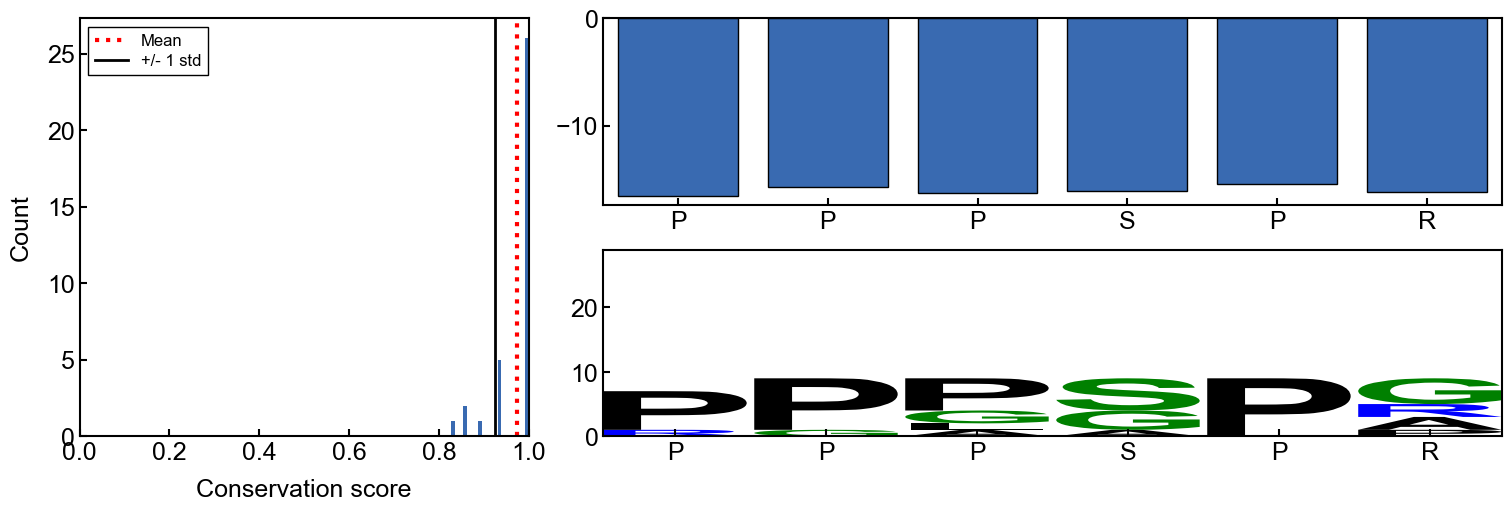

In [165]:
og = group_tools.ConserGene(zscores[zscores['reference_index']==1497]['json_file'].values[0], filepath_converter=table_file_converter)
score_ob=og.get_aln_score_obj('Tetrapoda', 'aln_property_entropy', filepath_converter=table_file_converter)
score_ob.plot_conservation_mosaic(strip_gaps=False)
print(score_ob.bg_std)
print(score_ob.bg_mean)

0.08248297231684677
0.8628637489434269


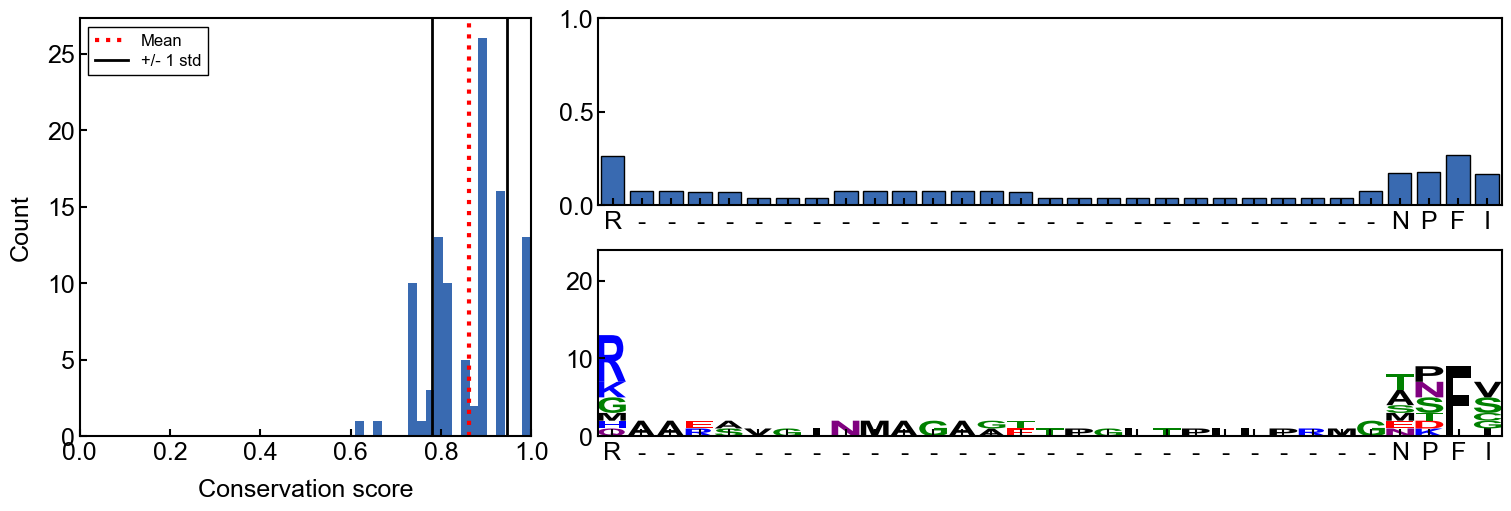

In [166]:
og = group_tools.ConserGene(zscores[zscores['reference_index']==761]['json_file'].values[0], filepath_converter=table_file_converter)
score_ob=og.get_aln_score_obj('Tetrapoda', 'aln_property_entropy', filepath_converter=table_file_converter)
f, axd = score_ob.plot_conservation_mosaic(strip_gaps=False, z_score=False)
axd['scores'].set_ylim(0, 1)
print(score_ob.bg_std)
print(score_ob.bg_mean)

1.8678199193417443e-08
0.8531678170334077
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQVKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQVKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQVKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGPS
LRRQMKNIVHNYSEAEIKVREATSNDPWGP

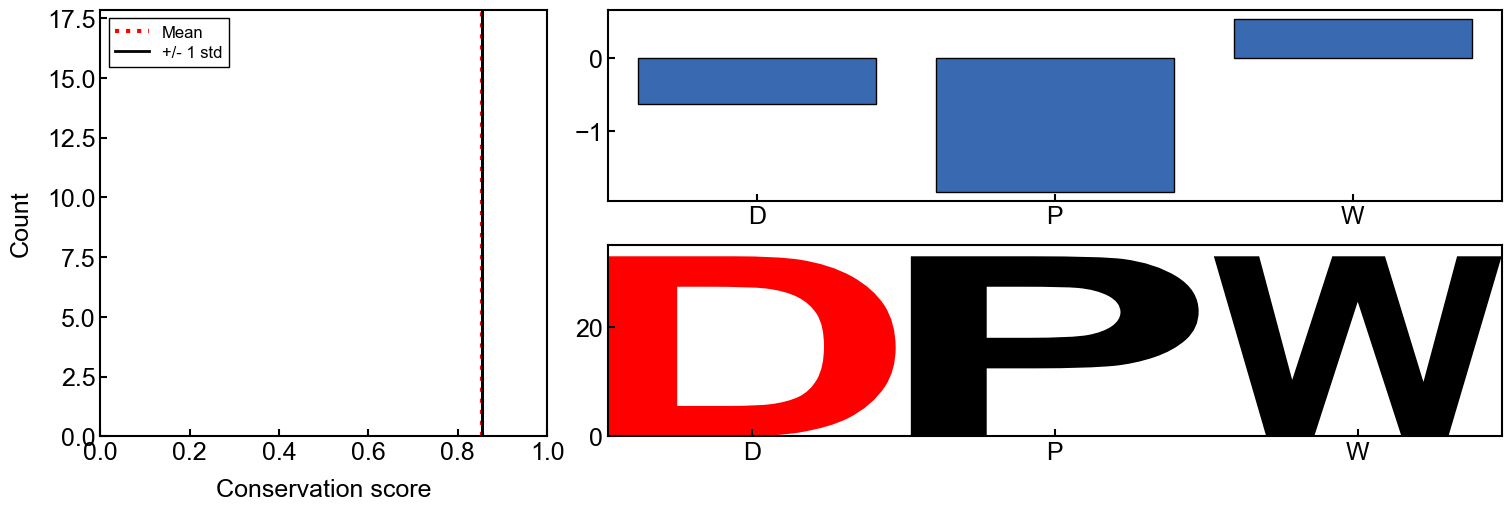

In [167]:
og = group_tools.ConserGene(zscores[zscores['reference_index']==185]['json_file'].values[0], filepath_converter=table_file_converter)
score_ob=og.get_aln_score_obj('Tetrapoda', 'aln_property_entropy', filepath_converter=table_file_converter)
score_ob.plot_conservation_mosaic(strip_gaps=False)
print(score_ob.bg_std)
print(score_ob.bg_mean)
for s in score_ob.aln[:,score_ob.idr_aln_start : score_ob.idr_aln_end]:
    print(str(s.seq))
# print(score_ob.info_dict.keys())

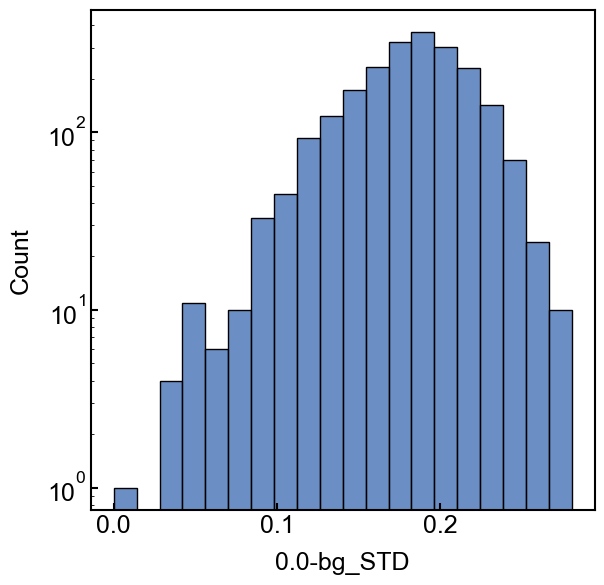

In [168]:
fig, ax = plt.subplots()
sns.histplot(zscores['0.0-bg_STD'], bins=20, ax=ax)
ax.set_yscale('log')

In [169]:
def _filter_std(df, std_col, std_thresh):
    return df[df[std_col] > std_thresh].copy()

def filter_all_std(dfin, index_columns, std_thresh):
    df = dfin.copy()
    for i in index_columns:
        df = _filter_std(df, f'{i}-bg_STD', std_thresh)
    return df

print(len(zscores))
temp = filter_all_std(zscores, score_indexes, 0.05)
print(len(temp))

2203
2184


In [170]:
zscores_filtered = filter_all_std(zscores, score_indexes, 0.05)
PASSING_REF_ID_LIST = zscores_filtered['reference_index'].unique()

# export tables for bootstrapping analysis

In [26]:
score_key_df2.to_csv('./z_scores_score_key.csv', index=False)
zscores_filtered.to_csv('./z_scores_wideform.csv', index=False)